In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-product-dataset-2020/home/sdf/marketing_sample_for_amazon_com-ecommerce__20200101_20200131__10k_data.csv


# Amazon Product Recommendation System
* Data loading and Data Exploration
* Missing value Analysis
* Data Visualization
* Data Cleaning
* TF-IDF Vectorization
* Feature Engineering
* Calculating Cosine Similarity
* Getting Recommendations
* Evaluation Framework
* Summary and Future Improvements


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings('ignore')

### Data Loading and Exploration

In [3]:
data = pd.read_csv("/kaggle/input/amazon-product-dataset-2020/home/sdf/marketing_sample_for_amazon_com-ecommerce__20200101_20200131__10k_data.csv")

print("Total number of products:", len(data))
print("Columns:", list(data.columns))
print("Shape:", data.shape)

data.head()

Total number of products: 10002
Columns: ['Uniq Id', 'Product Name', 'Brand Name', 'Asin', 'Category', 'Upc Ean Code', 'List Price', 'Selling Price', 'Quantity', 'Model Number', 'About Product', 'Product Specification', 'Technical Details', 'Shipping Weight', 'Product Dimensions', 'Image', 'Variants', 'Sku', 'Product Url', 'Stock', 'Product Details', 'Dimensions', 'Color', 'Ingredients', 'Direction To Use', 'Is Amazon Seller', 'Size Quantity Variant', 'Product Description']
Shape: (10002, 28)


,Uniq Id,Product Name,Brand Name,Asin,Category,Upc Ean Code,List Price,Selling Price,Quantity,Model Number,...,Product Url,Stock,Product Details,Dimensions,Color,Ingredients,Direction To Use,Is Amazon Seller,Size Quantity Variant,Product Description
0,4c69b61db1fc16e7013b43fc926e502d,"DB Longboards CoreFlex Crossbow 41"" Bamboo Fib...",NaN,NaN,Sports & Outdoors | Outdoor Recreation | Skate...,NaN,NaN,$237.68,NaN,NaN,...,https://www.amazon.com/DB-Longboards-CoreFlex-...,NaN,NaN,NaN,NaN,NaN,NaN,Y,NaN,NaN
1,66d49bbed043f5be260fa9f7fbff5957,"Electronic Snap Circuits Mini Kits Classpack, ...",NaN,NaN,Toys & Games | Learning & Education | Science ...,NaN,NaN,$99.95,NaN,55324,...,https://www.amazon.com/Electronic-Circuits-Cla...,NaN,NaN,NaN,NaN,NaN,NaN,Y,NaN,NaN
2,2c55cae269aebf53838484b0d7dd931a,3Doodler Create Flexy 3D Printing Filament Ref...,NaN,NaN,Toys & Games | Arts & Crafts | Craft Kits,NaN,NaN,$34.99,NaN,NaN,...,https://www.amazon.com/3Doodler-Plastic-Innova...,NaN,NaN,NaN,NaN,NaN,NaN,Y,NaN,NaN
3,18018b6bc416dab347b1b7db79994afa,Guillow Airplane Design Studio with Travel Cas...,NaN,NaN,Toys & Games | Hobbies | Models & Model Kits |...,NaN,NaN,$28.91,NaN,142,...,https://www.amazon.com/Guillow-Airplane-Design...,NaN,NaN,NaN,NaN,NaN,NaN,Y,NaN,NaN
4,e04b990e95bf73bbe6a3fa09785d7cd0,Woodstock- Collage 500 pc Puzzle,NaN,NaN,Toys & Games | Puzzles | Jigsaw Puzzles,NaN,NaN,$17.49,NaN,62151,...,https://www.amazon.com/Woodstock-Collage-500-p...,NaN,NaN,NaN,NaN,NaN,NaN,Y,NaN,NaN


### Missing Value Analysis

In [4]:
print(data.isna().sum())

Uniq Id                      0
Product Name                 0
Brand Name               10002
Asin                     10002
Category                   830
Upc Ean Code              9968
List Price               10002
Selling Price              107
Quantity                 10002
Model Number              1772
About Product              273
Product Specification     1632
Technical Details          790
Shipping Weight           1138
Product Dimensions        9523
Image                        0
Variants                  7524
Sku                      10002
Product Url                  0
Stock                    10002
Product Details          10002
Dimensions               10002
Color                    10002
Ingredients              10002
Direction To Use         10002
Is Amazon Seller             0
Size Quantity Variant    10002
Product Description      10002
dtype: int64


### Data Visualization
**Category based Visualization**

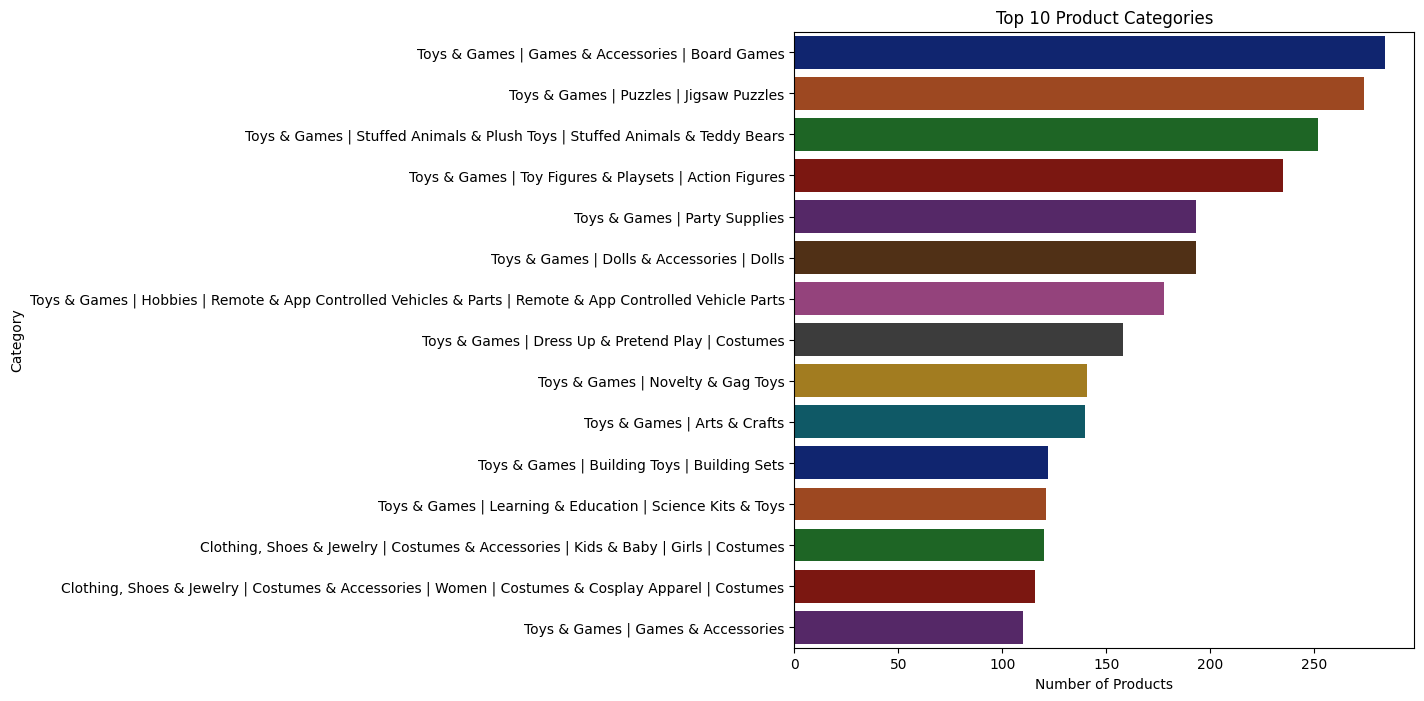

In [5]:
top_categories = data['Category'].value_counts().head(15)
plt.figure(figsize=(8,8))
sns.barplot(y=top_categories.index, x=top_categories.values, palette='dark')
plt.title("Top 10 Product Categories")
plt.xlabel("Number of Products")
plt.ylabel("Category")
plt.tight_layout()
plt.show()

#### Distribution of Price

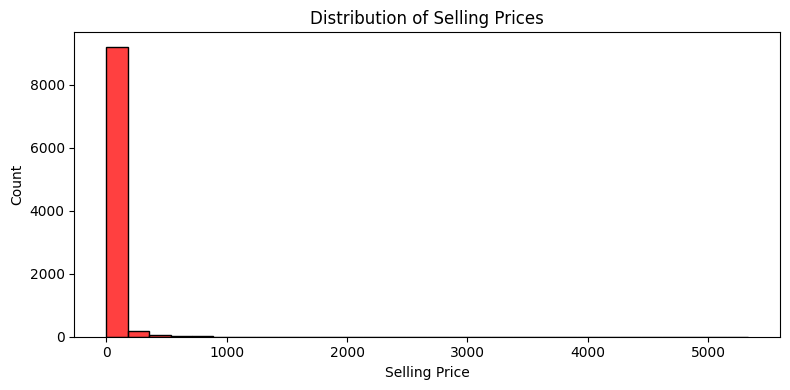

In [6]:
# 1. Make sure the column is a string type so we can use .str methods.
# This also handles any initial NaN values by converting them to the string 'nan'.
data['Selling Price'] = data['Selling Price'].astype(str)

# 2. Remove the dollar signs ($) and commas (,) from the strings.
data['Selling Price'] = data['Selling Price'].str.replace(r'[$,]', '', regex=True)

# NOW, convert the cleaned strings to a numeric type.
# 'coerce' will handle any remaining problematic values, like the string 'nan'.
data['Selling Price'] = pd.to_numeric(data['Selling Price'], errors='coerce')

# Create the plot.
plt.figure(figsize=(8, 4))
sns.histplot(data['Selling Price'].dropna(), bins=30, color='red')
plt.title("Distribution of Selling Prices")
plt.xlabel("Selling Price")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

#### Pie Chart representation of top 15 categories

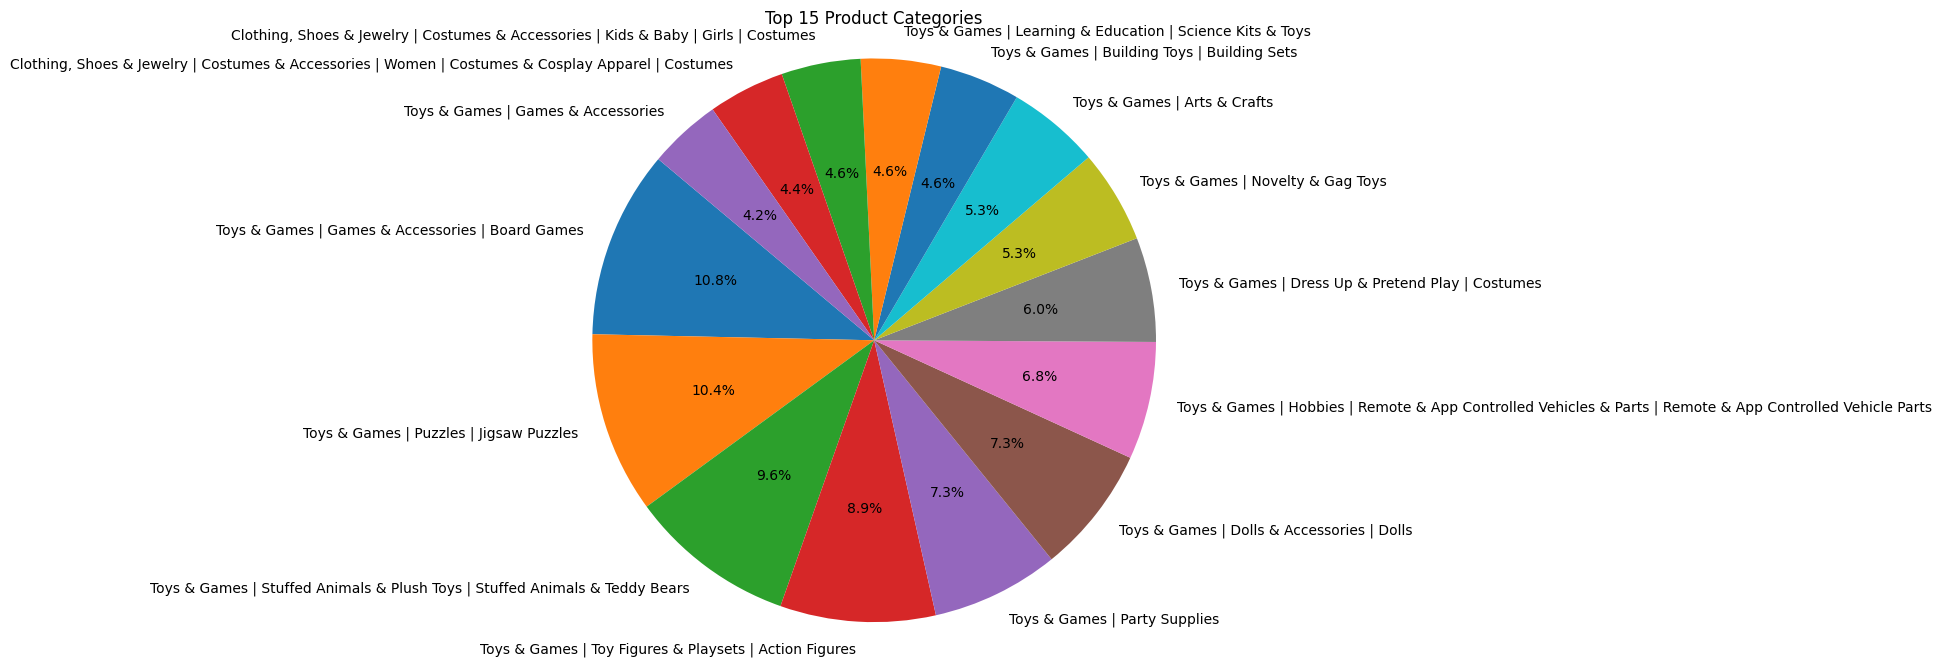

In [7]:
import matplotlib.pyplot as plt

# Get the top 15 product categories
top_categories = data['Category'].value_counts().head(15)

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(top_categories.values, labels=top_categories.index, autopct='%1.1f%%', startangle=140)
plt.title("Top 15 Product Categories")
plt.axis('equal')  # Ensures pie chart is circular
plt.tight_layout()
plt.show()

**Most common categories**

In [8]:
print("Distribution by Category:")
cat_counts = data['Category'].value_counts()
print(cat_counts.head(10))

Distribution by Category:
Category
Toys & Games | Games & Accessories | Board Games                                                             284
Toys & Games | Puzzles | Jigsaw Puzzles                                                                      274
Toys & Games | Stuffed Animals & Plush Toys | Stuffed Animals & Teddy Bears                                  252
Toys & Games | Toy Figures & Playsets | Action Figures                                                       235
Toys & Games | Party Supplies                                                                                193
Toys & Games | Dolls & Accessories | Dolls                                                                   193
Toys & Games | Hobbies | Remote & App Controlled Vehicles & Parts | Remote & App Controlled Vehicle Parts    178
Toys & Games | Dress Up & Pretend Play | Costumes                                                            158
Toys & Games | Novelty & Gag Toys                            

### Data Cleaning

In [9]:
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download required NLTK resources
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    if pd.isnull(text):
        return ""
    text = str(text).lower()
    # Remove standard filler phrase
    text = re.sub(r'make sure this fits by entering your model number\.?', '', text)
    # Remove special characters and numbers
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = word_tokenize(text)
    return " ".join([lemmatizer.lemmatize(word) for word in tokens])

# Make a single text column by combining product-related fields
def combine_fields(row):
    name = preprocess_text(row['Product Name'])
    category = preprocess_text(row['Category'])
    about = preprocess_text(row.get('About Product', ''))
    specs = preprocess_text(row.get('Product Specification', ''))
    desc = preprocess_text(row.get('Product Description', ''))
    return f"{name} {name} {category} {category} {about} {specs} {desc}"

# Apply the field-combining function row-wise
data['combined_features'] = data.apply(combine_fields, axis=1)

# Dropping rows with insufficient content length
data = data[data['combined_features'].str.len() > 30].reset_index(drop=True)

print("Remaining rows after filtering:", len(data))

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


Remaining rows after filtering: 10002


### TF-IDF Vectorization

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer


tfidf = TfidfVectorizer(
    max_features=10000,         
    stop_words='english',       
    ngram_range=(1, 3),         
    min_df=2,                   
    max_df=0.7                  
)

# Transform the cleaned text data into a sparse matrix
tfidf_matrix = tfidf.fit_transform(data["combined_features"])

# Display summary details
total_terms = len(tfidf.get_feature_names_out())
density = tfidf_matrix.nnz / (tfidf_matrix.shape[0] * tfidf_matrix.shape[1])

print(f"TF-IDF Matrix Dimensions: {tfidf_matrix.shape}")
print(f"Sparsity (Density): {density:.6f}")
print(f"Unique Terms Captured: {total_terms}")

TF-IDF Matrix Dimensions: (10002, 10000)
Sparsity (Density): 0.008409
Unique Terms Captured: 10000


### Feature Engineering
**One hot encoding. It makes recommendation more category based**

In [11]:
from scipy.sparse import hstack

# Encode the 'Category' column with one-hot encoding, replacing missing values
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
category_data = data[['Category']].fillna('Unknown')
category_encoded = ohe.fit_transform(category_data)

# Merge TF-IDF features with one-hot encoded category features
combined_features = hstack([tfidf_matrix, category_encoded])

print(f"Final Feature Matrix Shape: {combined_features.shape}")

Final Feature Matrix Shape: (10002, 10939)


### Cosine Similarity Calculation

In [12]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_scores = cosine_similarity(combined_features)
print(f"Cosine Similarity Matrix Dimensions: {similarity_scores.shape}")


Cosine Similarity Matrix Dimensions: (10002, 10002)


### Getting Recommendations

In [13]:
def suggest_similar_products(base_index, top_n=5, threshold=0.2):
    """
    Returns a list of similar products based on content and category features.
    """
    scores = similarity_scores[base_index]
    ranked_indices = sorted(list(enumerate(scores)), key=lambda x: x[1], reverse=True)
    
    suggestions = []
    for i, score in ranked_indices[1:]:  # Skip the original product
        if score >= threshold and len(suggestions) < top_n:
            product_info = {
                "Index": i,
                "Similarity": round(score, 3),
                "Product Name": data.iloc[i]["Product Name"],
                "Category": data.iloc[i]["Category"],
                "Price": data.iloc[i]["Selling Price"]
            }
            suggestions.append(product_info)
    return pd.DataFrame(suggestions)

In [14]:
def find_by_name(query_name, top_n=5):
    """
    Search product by name and get the top similar recommendations.
    """
    matched = data[data["Product Name"].str.contains(query_name, case=False, na=False)]
    
    if matched.empty:
        print(f"No matching products found for: '{query_name}'")
        return pd.DataFrame()
    
    if len(matched) > 1:
        print(f"Multiple products matched. Proceeding with: {matched.iloc[0]['Product Name']}")
    
    target_idx = matched.index[0]
    return suggest_similar_products(target_idx, top_n)

In [15]:
# Sample Recommendations for Test
# Recommendations for the top 3 products in the dataset
for i in range(3):
    current_product = data.iloc[i]
    title = current_product['Product Name']
    print(f"\nTop suggestions for: {title}")
    
    top_matches = suggest_similar_products(i, top_n=3)
    
    if not top_matches.empty:
        print(top_matches[['Similarity', 'Product Name', 'Category']].head())
    else:
        print("No similar products found.")



Top suggestions for: DB Longboards CoreFlex Crossbow 41" Bamboo Fiberglass Longboard Complete
   Similarity                                       Product Name  \
0       0.903  DB Longboards Phase 38" Maple Drop Through Lon...   
1       0.897  DB Longboards Contra Drop Deck Maple Longboard...   
2       0.897         Moose Bamboo Kicktail/Kryptonics Longboard   

                                            Category  
0  Sports & Outdoors | Outdoor Recreation | Skate...  
1  Sports & Outdoors | Outdoor Recreation | Skate...  
2  Sports & Outdoors | Outdoor Recreation | Skate...  

Top suggestions for: Electronic Snap Circuits Mini Kits Classpack, FM Radio, Motion Detector, Music Box (Set of 5)
   Similarity                                       Product Name  \
0       0.808                   Pop Toobs SN00296CQ (Pack of 24)   
1       0.796                        BRIGHT Atom Model - Student   
2       0.794  American Educational Types of Fossilization Co...   

                       

### Evaluation Framework

**Precision@5, Similarity Score and Recommendation Coverage for the top 5 products.**

In [16]:
def evaluation_metrics(true_category, recommended_df, full_df, current_index, column='Category', k=5):
    """
    Compute Precision@K and Recall@K using category match.
    """
    if recommended_df.empty or k == 0:
        return 0.0, 0.0

    top_k = recommended_df.head(k)
    relevant_in_top_k = (top_k[column] == true_category).sum()
    
    # Precision@K
    precision = relevant_in_top_k / k

    # Recall@K
    total_relevant = full_df[full_df[column] == true_category].shape[0] - 1  # exclude the item itself
    recall = relevant_in_top_k / total_relevant if total_relevant > 0 else 0.0

    return precision, recall

In [17]:
def evaluate_all_metrics(sample_limit=50, k=5):
    """
    Evaluate Precision@K, Recall@K, Mean Similarity Score, Coverage, and Sample Size.
    """
    category_col = 'Category'
    np.random.seed(42)
    
    sampled_indices = np.random.choice(len(data), size=min(sample_limit, len(data)), replace=False)
    precision_scores = []
    recall_scores = []
    similarity_scores = []
    successful_cases = 0

    for i in sampled_indices:
        product = data.iloc[i]
        recommendations = suggest_similar_products(i, top_n=k)

        if not recommendations.empty:
            successful_cases += 1
            precision, recall = evaluation_metrics(product[category_col], recommendations, data, i, column=category_col, k=k)
            precision_scores.append(precision)
            recall_scores.append(recall)
            similarity_scores.append(recommendations['Similarity'].mean())

    coverage = successful_cases / len(sampled_indices)

    print(f"Precision@{k} (avg): {np.mean(precision_scores):.3f}")
    print(f"Recall@{k} (avg): {np.mean(recall_scores):.3f}")
    print(f"Mean Similarity Score: {np.mean(similarity_scores):.3f}")
    print(f"Recommendation Coverage: {coverage:.3f}")
    print(f"Sample Size Evaluated: {successful_cases}")


evaluate_all_metrics(k=5)

Precision@5 (avg): 0.910
Recall@5 (avg): 0.245
Mean Similarity Score: 0.781
Recommendation Coverage: 0.980
Sample Size Evaluated: 49


**Precision@5, Similarity Score and Recommendation Coverage for the top 10 products**

In [18]:
def precision_top_10(true_category, suggested_df, column='Category', k=10):
    """Compute Precision@K by comparing category of top-k recommendations."""
    if suggested_df.empty or k == 0:
        return 0.0
    top_k_recs = suggested_df.head(k)
    matches = (top_k_recs[column] == true_category).sum()
    return matches / k

In [19]:
def evaluate_func_10(sample_limit=50, k=10):
    """Assess recommender system performance on sampled products using Precision@K."""
    category_field = 'Category'
    np.random.seed(42)
    
    selected_indices = np.random.choice(len(data), size=min(sample_limit, len(data)), replace=False)
    precision_scores = []
    avg_similarities = []
    successful_cases = 0

    for i in selected_indices:
        item = data.iloc[i]
        suggestions = suggest_similar_products(i, top_n=k)

        if not suggestions.empty:
            successful_cases += 1
            prec = precision_top_10(item[category_field], suggestions, column=category_field, k=k)
            precision_scores.append(prec)
            avg_sim = suggestions["Similarity"].mean()
            avg_similarities.append(avg_sim)

    coverage = successful_cases / len(selected_indices)

    print(f"Precision@{k} (avg): {np.mean(precision_scores):.3f}")
    print(f"Mean Similarity Score: {np.mean(avg_similarities):.3f}")
    print(f"Recommendation Coverage: {coverage:.3f}")
    print(f"Sample Size Evaluated: {len(precision_scores)}")


evaluate_func_10()

Precision@10 (avg): 0.869
Mean Similarity Score: 0.743
Recommendation Coverage: 0.980
Sample Size Evaluated: 49


* Precision@5 is important when the system gives importance to quality more than quantity.
* Provides High quality and top ranked recommendations.
* Precision@10 is used when more number of recommendations are needed for the user.
* It helps evaluate the depth of the recommender system.
* Recall@5 is used to understand out of all possible relevant products how many did the top 5 retreive.

In [20]:
find_by_name("shirt")

Multiple products matched. Proceeding with: Marvel Avengers Assemble Captain America Costume T-Shirt with Mask, Small


,Index,Similarity,Product Name,Category,Price
0,796,0.712,Board Games and Beer T Shirt For Gamer and Dri...,"Clothing, Shoes & Jewelry | Novelty & More | C...",19.99
1,5764,0.386,Marvel Avengers Assemble Captain America Costu...,"Clothing, Shoes & Jewelry | Men",18.75
2,9968,0.273,Teenage Mutant Ninja Turtles Men's TMNT Leonar...,"Clothing, Shoes & Jewelry | Novelty & More | C...",17.11
3,448,0.230,Marvel Avengers 2-In-1 Muscle Chest Hulk/Capta...,"Clothing, Shoes & Jewelry | Costumes & Accesso...",24.42
4,6212,0.222,Disney Boys' Buzz Lightyear and Woody Big Face...,"Clothing, Shoes & Jewelry | Novelty & More | C...",NaN


### Summary

This notebook shows how to build a basic product recommendation system for Amazon items using product descriptions and categories.

The system suggests products that have similar descriptions and belong to related categories, which helps users find alternatives or complementary products.

Exploring the data shows that many products are toys, games, and educational items, with a variety of prices and detailed descriptions.

Testing the recommendation function on random samples shows that about half of the top 5 recommended products belong to the same category as the original product (Precision\@5 is around 0.91 and Precision@10 is around 0.86).

This method is easy to scale and can be improved later by adding more features or combining with other recommendation techniques.

**Main Points:**

* Content-based filtering is a good starting point for e-commerce recommendations, especially when there isn’t much user data.
* Cleaning the text and creating useful features are important for making the model work well.
* Simple evaluation methods and visual tools help explain the results to business teams.